In [ ]:
pip install import_ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=c72077849a79ef001762eab1b42d1ccfd784dea70d06a3367104f0ca6dc97702
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


**Import notebooks from drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
  
%cd /content/drive/My\ Drive/MLDLProjects/Lande_Napolitano_Pipoli/Project_root
 
import import_ipynb
from cifar100_Rseed import cifar_100
#from cifar100 import cifar_100
from net import resnet32
from tqdm.notebook import tqdm

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/MLDLProjects/Lande_Napolitano_Pipoli/Project_root
importing Jupyter notebook from cifar100_Rseed.ipynb
IMPORT CIFAR DONE
importing Jupyter notebook from net.ipynb
IMPORT NET DONE


In [ ]:
import torch
torch.backends.cudnn.benchmark=True
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import subprocess
from PIL import Image
from torch.utils.data import Subset, DataLoader
import torch.nn.functional as F
import copy
import seaborn as sn
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import confusion_matrix as s_cm


NUM_CLASSES=10

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Model class definition**

In [ ]:
class LearningWithoutForgetting(nn.Module):

  # param: classes is the initial number of classes for the model
    def __init__(self, CNN, CRITERION=nn.BCEWithLogitsLoss(), LR=2.0, NUM_EPOCHS=70, BATCH_SIZE=128, GAMMA=0.2, WEIGHT_DECAY=1e-5):

        # Network architecture
        super(LearningWithoutForgetting, self).__init__() # init of nn.Module
        self.model = CNN
        self.init_lr = LR
        self.num_epochs = NUM_EPOCHS
        self.batch_size = BATCH_SIZE
        self.milestones = [49, 63]
        self.pretrained = False
        self.momentum = 0.9
        self.weight_decay = WEIGHT_DECAY
        self.gamma = GAMMA

        self.feature_extractor = self.model.get_fm_out

        self.criterion = CRITERION

        self.n_classes = 0
        self.n_known = 0
        self.test_accs = []
        self.mapper = None


    def forward(self, x):
        self.model = self.model.cuda()
        return self.model.forward(x)


    def increment_classes(self, new_classes):
        """Add n classes in the final fc layer"""
        n = len(new_classes)
        in_features = self.classifier.in_features
        out_features = self.classifier.out_features
        weight = self.classifier.weight.data

        if self.n_known == 0:
            new_out_features = n
        else:
            new_out_features = out_features + n
        self.model.classifier = nn.Linear(in_features, new_out_features, bias=False)
        self.classifier = self.model.classifier
        
        self.classifier.weight.data[:out_features] = weight
        self.n_classes += n


    def classify(self, image):
        _, preds = torch.max(torch.softmax(self.forward(image), dim=1), dim=1, keepdim=False)
        return preds


    def update(self, dataset, mapper):

        # Save a copy to compute distillation outputs
        prev_model = copy.deepcopy(self)
        prev_model.eval().cuda()

        self.n_classes += 10

        loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size,shuffle=True, num_workers=4, drop_last=True) # each mini batch will have 128 images
            
        optimizer = optim.SGD(self.model.parameters(), lr=self.init_lr, weight_decay=self.weight_decay, momentum=self.momentum)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=self.milestones, gamma=self.gamma)

        for epoch in tqdm(range(self.num_epochs)):

            losses = []
            for _, images, labels in loader:
                images = Variable(torch.FloatTensor(images)).cuda()
                labels = torch.tensor([torch.tensor(mapper[c.item()]) for c in labels])
                labels = Variable(labels).cuda()
                optimizer.zero_grad()
                logits = self.forward(images)

                y_hot = F.one_hot(labels, self.n_classes).float().cuda()
                
                if self.n_known:
                    dist_target = prev_model.forward(images).cuda()
                    dist_target = torch.sigmoid(dist_target).cuda()

                    target = torch.cat((dist_target[:,:self.n_known], y_hot[:, self.n_known:self.n_classes]), dim=1)
                    loss = self.criterion(logits[:,:self.n_classes], target)
      
                else:
                    loss = self.criterion(logits[:,:self.n_classes],  y_hot[:,:self.n_classes])

                losses.append(loss.item())
                loss.backward()
                optimizer.step()

            scheduler.step()

    def __accuracy_on(self, dl, model, mapper):
        total = 0.0
        correct = 0.0
        for _, images, labels in dl:
            labels = torch.tensor([torch.tensor(mapper[c.item()]) for c in labels])
            images = Variable(images).cuda()
            preds = model.classify(images)
            total = total + len(labels)
            correct += (preds.data.cpu() == labels).sum()

        acc = 100 * correct / total
        return acc

    

    def train_model(self, randseed):

        cifarTrain = cifar_100(NUM_CLASSES, 'train', randseed)
        cifarTest = cifar_100(NUM_CLASSES, 'test', randseed)
        randomlist = cifarTrain.get_classes_list()
        self.mapper = cifarTrain.get_dictionary()


        for s in range(10):

            print("\n")
            print('-' * 80)
            
            print(f"ITERATION: %d /10" % (s+1))

            print("Loading training examples for classes", randomlist[s*NUM_CLASSES:s*NUM_CLASSES + NUM_CLASSES])
            batchindexes = cifarTrain.getClassIndexes(randomlist[s*NUM_CLASSES:s*NUM_CLASSES + NUM_CLASSES])
            batch = Subset(cifarTrain, batchindexes)
            
            train_loader = torch.utils.data.DataLoader(batch, batch_size=self.batch_size,shuffle=True, num_workers=12)

            testindexes = cifarTest.getClassIndexes(randomlist[0:s*NUM_CLASSES + NUM_CLASSES])
            test_set = Subset(cifarTest, testindexes)
            test_loader = torch.utils.data.DataLoader(test_set, batch_size=self.batch_size,shuffle=True, num_workers=12)
        
            print("Batch size train: {} - Batch size test: {}".format(len(batch), len(test_set)))

            self.train() # module method to set the model to train mode
            self.update(batch, self.mapper)
            self.eval() # module method to set the model to evaluation mode

            self.n_known = self.n_classes

            train_acc = self.__accuracy_on(train_loader, self, self.mapper)
            print ('Train Accuracy: %.2f' % train_acc)

            test_acc = self.__accuracy_on(test_loader, self, self.mapper)
            print ('Test Accuracy: %.2f' % test_acc)

            self.test_accs.append(test_acc.item())

            print('-' * 80)

        self.eval()
        return self
  
    def plot_test_accuracy(self, file=None):
        classes = np.arange(10, 110, 10)
        title = "LWF - Accuracy on the test set"

        plt.figure(figsize=(8, 5))
        plt.title(title)
        plt.plot(classes, self.test_accs, c='orange')
        plt.scatter(classes, self.test_accs, c='orange')
        plt.xlabel("Classes")
        plt.ylabel("Accuracy")
        plt.grid()
        if file: 
            plt.savefig(title + '.png')
        plt.show()
        return self.test_accs

    def compute_confusion_matrix(self, plot=False):
      
        cifar_test = cifar_100(100, 'test')
        dl = torch.utils.data.DataLoader(cifar_test, batch_size=128,shuffle=True, num_workers=4)
        y_true = []
        y_pred = []
        for _, images, labels in dl:
            images = Variable(images).cuda()
            y_true.extend(labels)
            y_pred_tmp = self.classify(images)
            y_pred_tmp = [p.item() for p in y_pred_tmp]
            y_pred.extend(y_pred_tmp)
        
        y_true = [self.mapper[l.item()] for l in y_true]
        acc_matrix = s_cm(y_true, y_pred)

        if plot:
            plt.figure(figsize=(11,11))
            df_cm = pd.DataFrame(acc_matrix)
            sn.heatmap(df_cm, square=True, xticklabels=20, yticklabels=20)
            plt.title("LWF confusion matrix")
            plt.show()

        return acc_matrix


**Model usage**

Files already downloaded and verified
Files already downloaded and verified


--------------------------------------------------------------------------------
ITERATION: 1 /10
Loading training examples for classes [28, 7, 17, 45, 46, 91, 63, 13, 95, 59]
Batch size train: 5000 - Batch size test: 1000



Train Accuracy: 95.78
Test Accuracy: 79.00
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
ITERATION: 2 /10
Loading training examples for classes [90, 69, 93, 22, 20, 39, 6, 61, 19, 81]
Batch size train: 5000 - Batch size test: 2000



Train Accuracy: 97.34
Test Accuracy: 65.05
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
ITERATION: 3 /10
Loading training examples for classes [96, 37, 76, 40, 43, 8, 1, 83, 2, 49]
Batch size train: 5000 - Batch size test: 3000



Train Accuracy: 96.02
Test Accuracy: 54.93
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
ITERATION: 4 /10
Loading training examples for classes [12, 27, 68, 29, 80, 86, 24, 11, 26, 51]
Batch size train: 5000 - Batch size test: 4000



Train Accuracy: 93.58
Test Accuracy: 47.60
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
ITERATION: 5 /10
Loading training examples for classes [82, 16, 72, 52, 60, 36, 14, 41, 73, 38]
Batch size train: 5000 - Batch size test: 5000



Train Accuracy: 93.16
Test Accuracy: 42.54
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
ITERATION: 6 /10
Loading training examples for classes [79, 50, 94, 54, 42, 15, 87, 5, 75, 78]
Batch size train: 5000 - Batch size test: 6000



Train Accuracy: 90.60
Test Accuracy: 39.32
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
ITERATION: 7 /10
Loading training examples for classes [35, 66, 99, 98, 3, 58, 77, 71, 23, 47]
Batch size train: 5000 - Batch size test: 7000



Train Accuracy: 90.72
Test Accuracy: 34.16
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
ITERATION: 8 /10
Loading training examples for classes [18, 64, 97, 34, 56, 89, 85, 30, 9, 25]
Batch size train: 5000 - Batch size test: 8000



Train Accuracy: 92.58
Test Accuracy: 30.30
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
ITERATION: 9 /10
Loading training examples for classes [70, 48, 57, 84, 92, 53, 67, 65, 10, 31]
Batch size train: 5000 - Batch size test: 9000



Train Accuracy: 90.50
Test Accuracy: 26.96
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
ITERATION: 10 /10
Loading training examples for classes [88, 33, 4, 21, 74, 32, 62, 0, 55, 44]
Batch size train: 5000 - Batch size test: 10000



Train Accuracy: 90.32
Test Accuracy: 23.32
--------------------------------------------------------------------------------
[79.0, 65.05000305175781, 54.93333435058594, 47.599998474121094, 42.540000915527344, 39.31666564941406, 34.157142639160156, 30.299999237060547, 26.955554962158203, 23.31999969482422]
Files already downloaded and verified


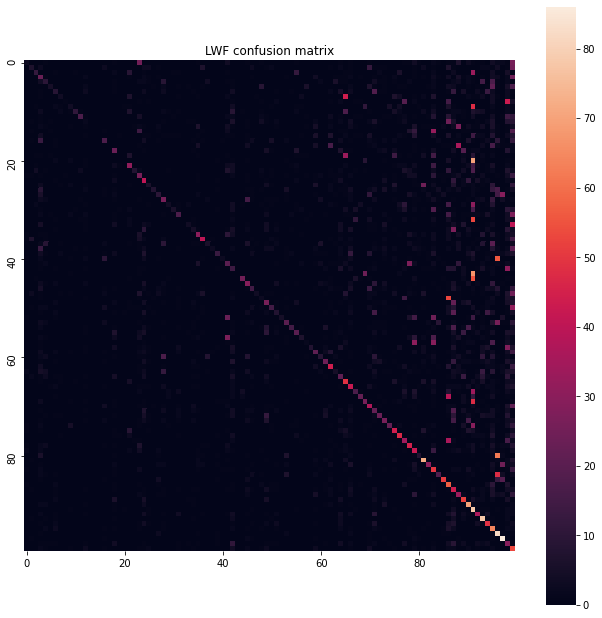

In [ ]:
model = LearningWithoutForgetting(CNN=resnet32(num_classes=100), NUM_EPOCHS=70).cuda()
model = model.train_model(981)

print(model.test_accs)

cm = model.compute_confusion_matrix(plot=True)